GROUP WORK PROJECT #2
MScFE 642 DEEP LEARNING FOR FINANCE
Group Number: 5280

Magdalena Ewa Nitefor|
Dejen Zelalem Nugusse|
Manjunath N Ramasubbiah



# Step 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

We are obligated to have a test sample from 01/01/2018 to 30/12/2022. Since it gives us 1258 observations for the test set, to have a reasonable amount of training data, we have decided to use the data from 01/01/2010 to 31/12/2018 as training sample.

The analyzed securities (hereafter portfolio components) are:
- SPY: SPDR S&P500 ETF, representing equity in the portfolio
- TLT: long-term fixed-income ETF, representing fixed income in the portfolio
- SHY: short-term fixed-income ETF, representing cash in the portfolio
- GLD: SPDR gold ETF, representing precious metals in the portfolio
- DBO: WTI oil ETF (ETC), representing commodities in the portfolio.

It is worth noticing that having gold- and oil-tracking ETFs in our portfolio is a known pair-trading strategy since the prices of both commodities often move in the same direction.

After downloading the data we convert it to discrete returns using the formula $r_t = \frac{P_t-P_{t-1}}{P_{t-1}}*100$ with multiplication by 100 as a computational tweak.

In [ ]:
# Download the data and use only the Adjusted Close price
tickers = ['SPY', 'TLT', 'SHY', 'GLD', 'DBO']
data = yf.download(tickers, start='2010-01-01', end='2022-12-30')['Adj Close']
# Convert to discrete returns
data = (data.pct_change()*100).dropna(axis=0)
data.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2010-01-05,0.925585,-0.091080,0.120371,0.264695,0.645862
2010-01-06,1.234579,1.649959,0.012094,0.070425,-1.338693
2010-01-07,-0.696865,-0.618781,-0.024143,0.422120,0.168193
2010-01-08,0.491212,0.496303,0.096306,0.332790,-0.044702
2010-01-11,-0.558651,1.328900,0.048006,0.139668,-0.548817


With the above-described split, we obtain:
- A total of 3270 observations, of which
- 2012 training observations, last 403 of which are used as validation set, and
- 1258 test observations.

WIthin the analyzed period there is one major crisis, the COVID-19 pandemic, which caused extreme plunges in all markets worldwide. Hence, in hindishgt we expect the models to perform especially poorly near March/April 2020.

In [ ]:
ts = data.index<='2017-12-31'

print('Total number of observations:', len(data))
print('Number of observations in the training set (including validation):', len(data[ts]))
print('Number of observations in the training set:', int(0.8*len(data[ts])))
print('Number of observations in the validation set:', len(data[ts])-int(0.8*len(data[ts])))
print('Number of observations in the test set:', len(data[data.index>'2017-12-31']))

Total number of observations: 3270
Number of observations in the training set (including validation): 2012
Number of observations in the training set: 1609
Number of observations in the validation set: 403
Number of observations in the test set: 1258


In [ ]:
# Split the datast into training, validation and test sets
data_train = data.iloc[:1609,:]
print('First 5 rows of training data\n', data_train.head(), '\n')
data_validation = data.iloc[1609:2012,:]
print('Last 5 rows of training data\n',data_validation.tail(), '\n')
data_test = data.iloc[2012:, :]
print('First 5 rows of test data\n',data_test.head())

First 5 rows of training data
 Ticker           DBO       GLD       SHY       SPY       TLT
Date                                                        
2010-01-05  0.925585 -0.091080  0.120371  0.264695  0.645862
2010-01-06  1.234579  1.649959  0.012094  0.070425 -1.338693
2010-01-07 -0.696865 -0.618781 -0.024143  0.422120  0.168193
2010-01-08  0.491212  0.496303  0.096306  0.332790 -0.044702
2010-01-11 -0.558651  1.328900  0.048006  0.139668 -0.548817 

Last 5 rows of training data
 Ticker           DBO       GLD       SHY       SPY       TLT
Date                                                        
2017-12-22  0.000000  0.523651 -0.035810 -0.026167  0.136438
2017-12-26  2.436556  0.686286 -0.011958 -0.119626  0.296568
2017-12-27 -0.297328  0.377767  0.047787  0.048654  1.302482
2017-12-28  0.695823  0.507236  0.011903  0.205743 -0.086740
2017-12-29  0.197425  0.651203  0.023854 -0.377070  0.157910 

First 5 rows of test data
 Ticker           DBO       GLD       SHY       SPY    

Below we have visualized historical prices of the analyzed securities and distinguished between training, validation and test subsets of the data.

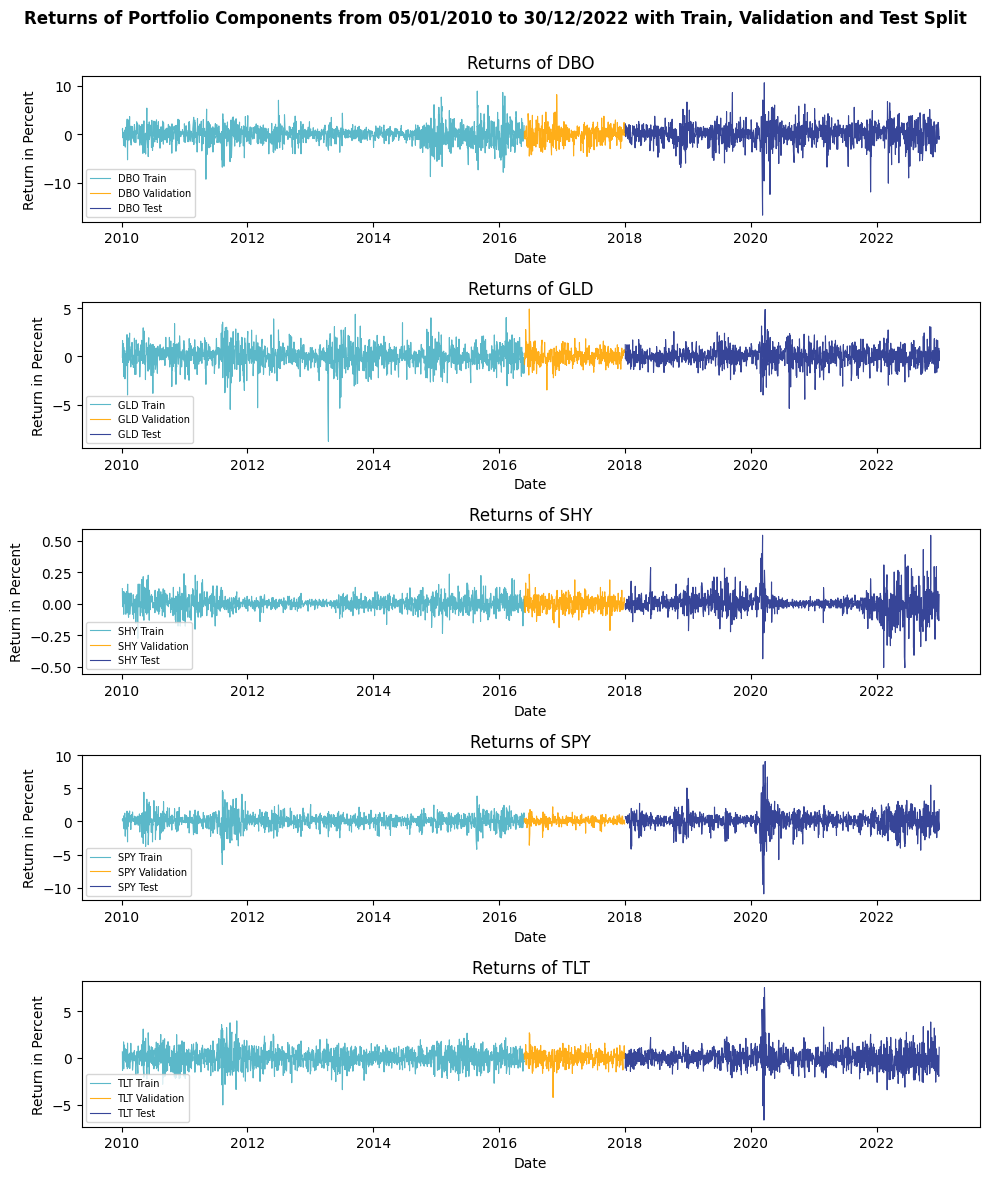

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(10,12))
for i, col in enumerate(data.columns):
  ax[i].plot(data_train[col], label=f'{col} Train', color='#49b1c3', alpha=0.9, linewidth=0.8)
  ax[i].plot(data_validation[col], label=f'{col} Validation', color='orange', alpha=0.9, linewidth=0.8)
  ax[i].plot(data_test[col], label=f'{col} Test', color='#21318d', alpha=0.9, linewidth=0.8)
  ax[i].legend(fontsize=7, loc='lower left')
  ax[i].set(xlabel='Date', ylabel='Return in Percent', title=f'Returns of {col}')
plt.suptitle('Returns of Portfolio Components from 05/01/2010 to 30/12/2022 with Train, Validation and Test Split\n', fontweight='bold')
plt.tight_layout()
plt.savefig('portfolio_plot.png')
plt.show();

We can see that every portfolio component displays a different behavior. Therefore, analyzing correlations of the training, validation and test sets can give a valuable insight.

An obvious observation, however, is the increased period of volatility, as mentioned before, around March-April 2020. Additionally, also as expected while working with securities returns, the returns resemble white noise with slight volatility clustering.

We proceed with correlation analysis of the portfolio components.

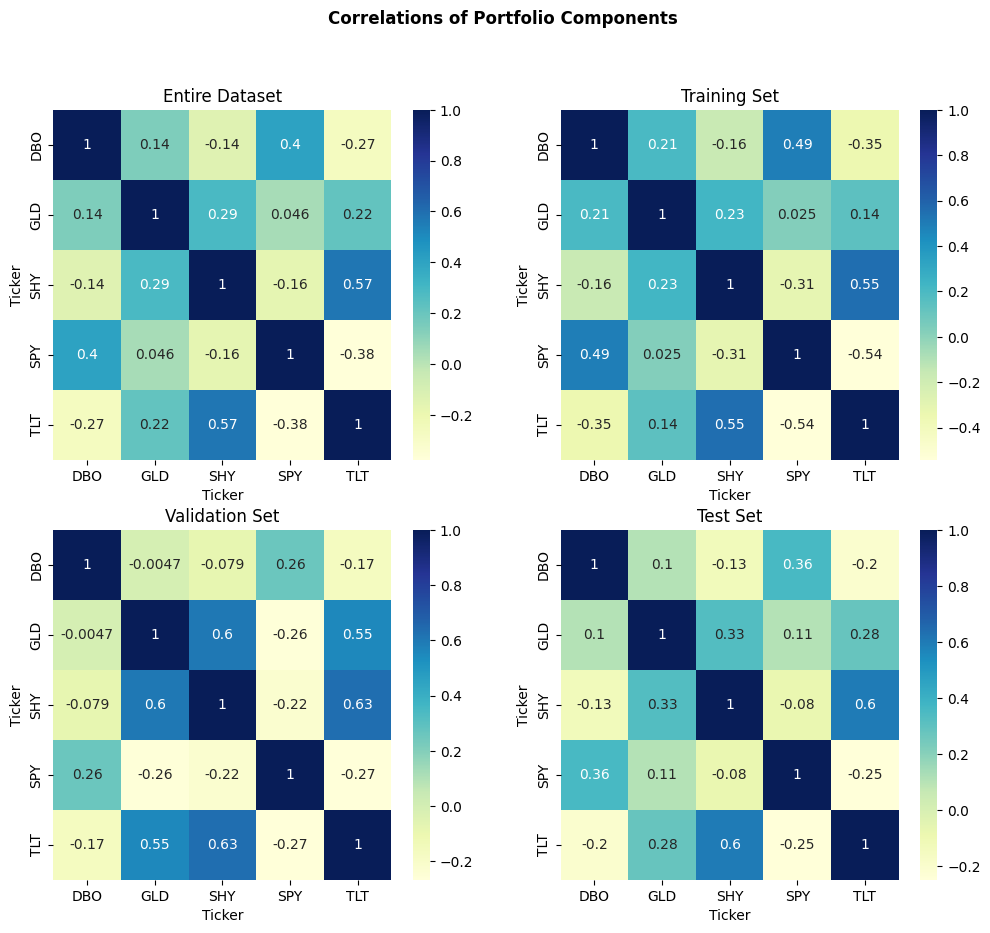

In [ ]:
# Calculate Pearson correlation coefficients
corr_data = data.corr()
corr_train = data_train.corr()
corr_validation = data_validation.corr()
corr_test = data_test.corr()

fig, ax = plt.subplots(2, 2, figsize=(12,10))
sns.heatmap(corr_data, ax=ax[0,0], annot=True, cmap='YlGnBu')
ax[0,0].set_title('Entire Dataset')
sns.heatmap(corr_train, ax=ax[0,1], annot=True, cmap='YlGnBu')
ax[0,1].set_title('Training Set')
sns.heatmap(corr_validation, ax=ax[1,0], annot=True, cmap='YlGnBu')
ax[1,0].set_title('Validation Set')
sns.heatmap(corr_test, ax=ax[1,1], annot=True, cmap='YlGnBu')
ax[1,1].set_title('Test Set')
plt.suptitle('Correlations of Portfolio Components', fontweight='bold')
plt.savefig('portfolio_correlations.png')
plt.show();

While the correlations of the entire dataset and the training set are similar (which is expected since the training set accounts for nearly 62% of the whole data), it is interesting to observe that the validation and test sets are characterized by different values of correlation coefficients.

This is potentially challenging for the models that we build in the next steps and might indicate that there can be a performance drop between training, validation and testing sets. While it is not expected to be impactful for single-security models, we expect it to arise as an issue in the multidimensional modeling part of this portfolio allocation task.

Let us examine a few particular correlation coefficients:
- In the entire dataset the observed correlations are at most moderate with a maximum of 0.57 between **SHY and TLT**, and this is consisnent across all subsets: training, validation and test. Since both components are ETFs on the U.S. Treasury bills, this conclusion is not a surprise.
- A somewhat interesting phenomenon occurs between **GLD and DBO**, where the correlations in training and test sets take different directions than in the validation set. We may expect it to impact validation performance of the joint model.
- An overall conclusion across all the analyzed timeframes is that the pairwise correlations between portfolio components are weak, indicating that we built a portoflio of components with practically independent returns.

To summarize, given the correlation coefficients, there is little regularity in the analzyed data across sub-periods, as compared with each other and with the entire dataset.

Another aspect of the portfolio components that we consider is time series decomposition into:
- Trend
- Seasonality
- Residuals.

This analysis would be more meaningful for raw prices rather than for discrete, white-noise-like returns, however, given the benchmark nature of the components, we still check whether there exists any kind of regularity.

In [ ]:
data_train.tail()

Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2016-05-19,0.336339,-0.191504,0.023578,-0.346495,0.432450
2016-05-20,0.111722,-0.133481,0.035359,0.631741,0.076893
2016-05-23,-0.558031,-0.284017,-0.011752,-0.136268,0.222801
2016-05-24,1.010101,-1.734104,-0.070742,1.296240,-0.444639
2016-05-25,1.777776,-0.272805,0.058990,0.678271,-0.377344


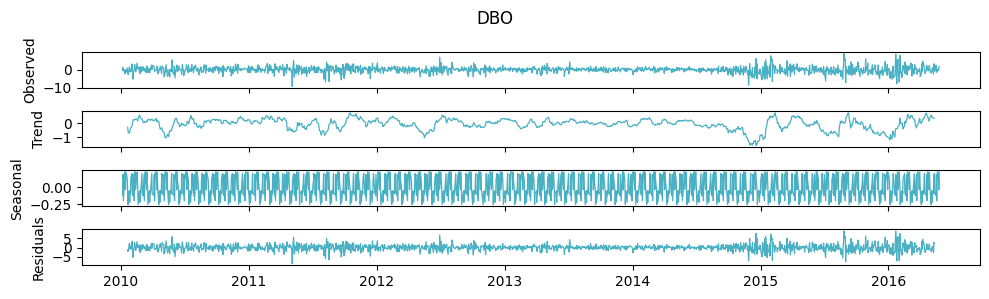

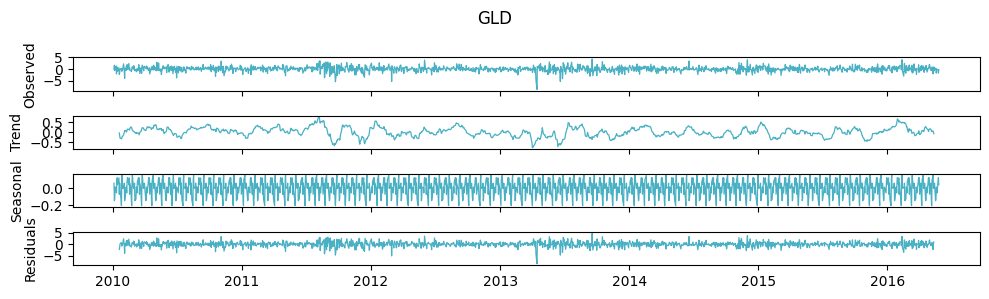

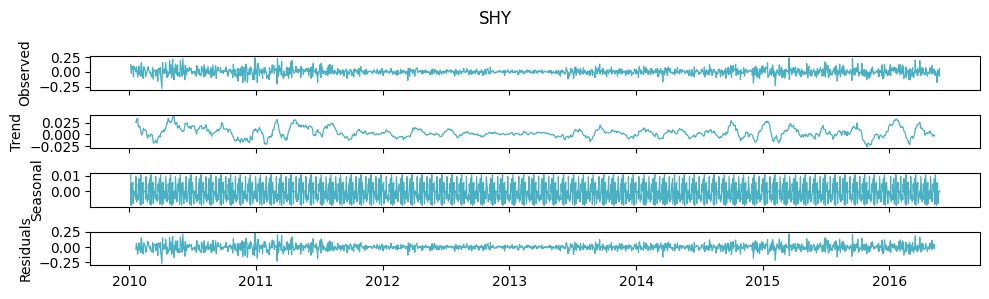

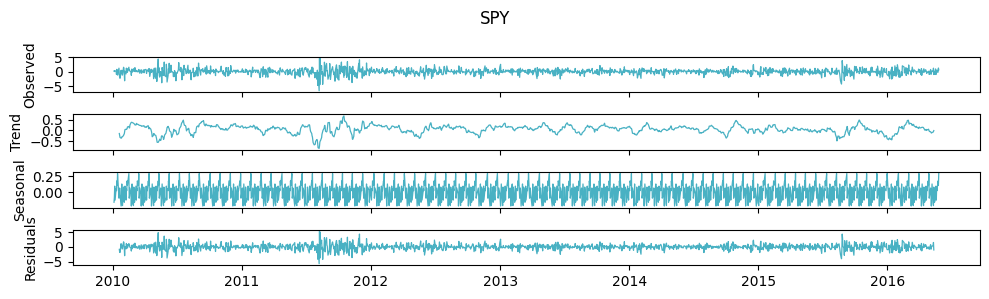

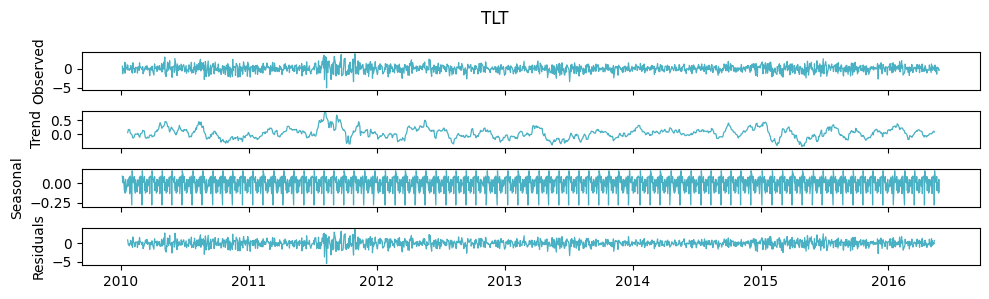

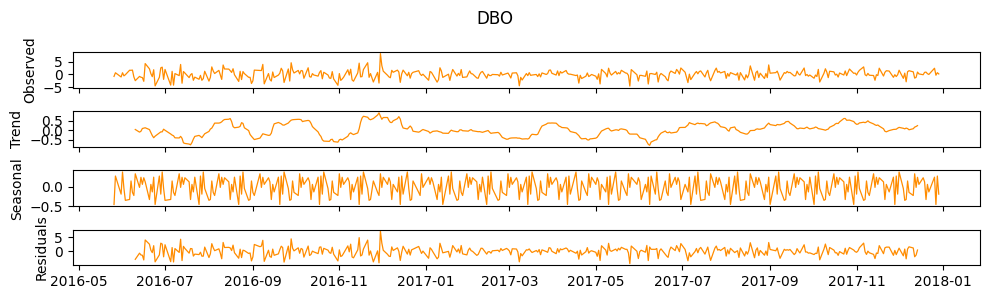

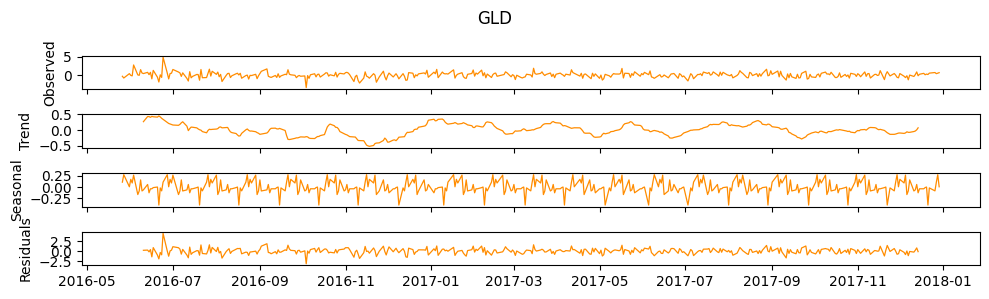

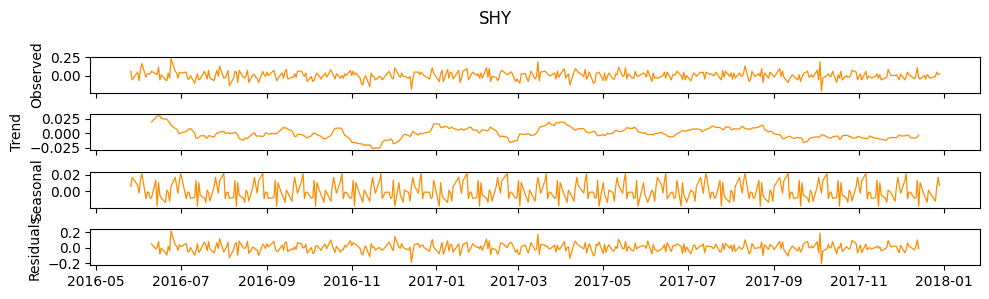

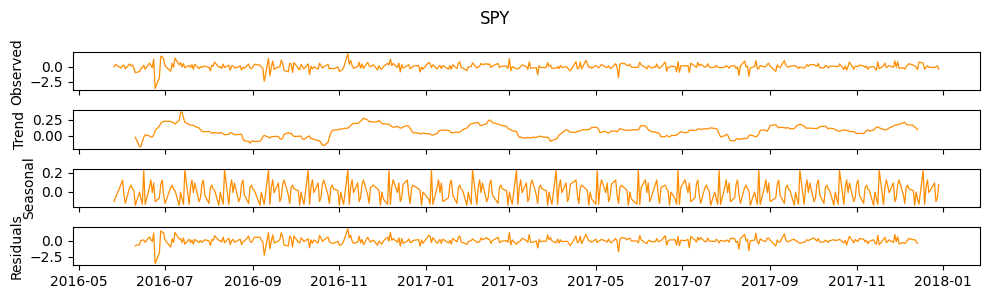

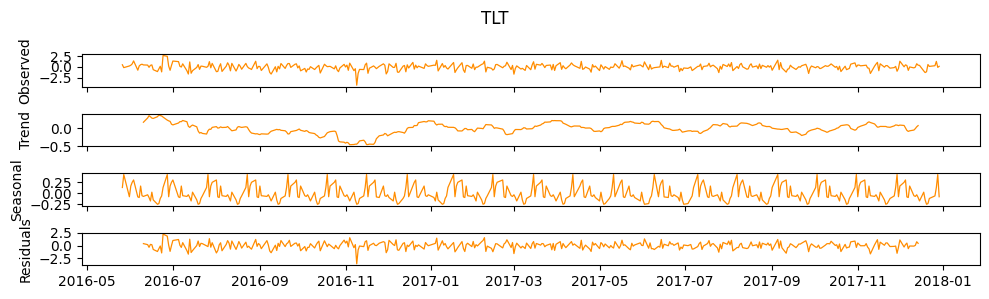

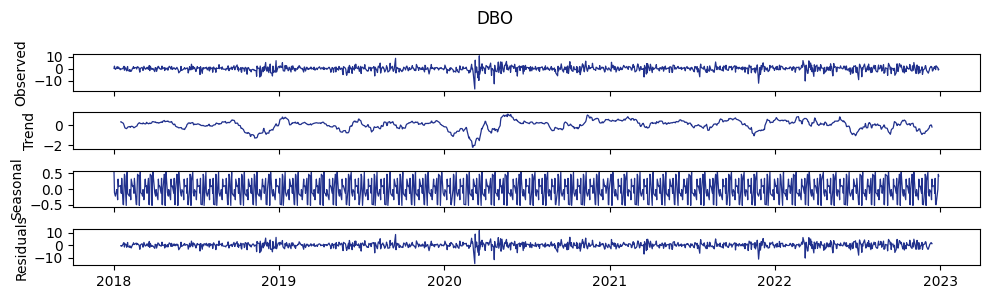

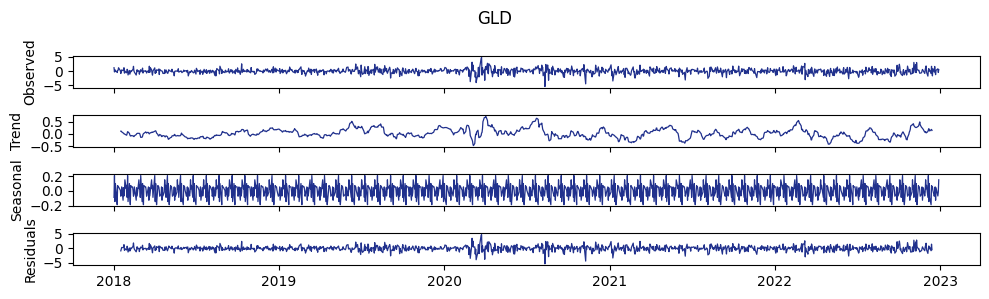

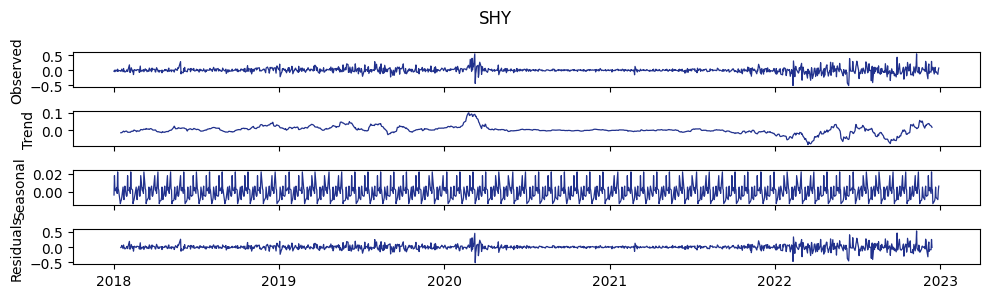

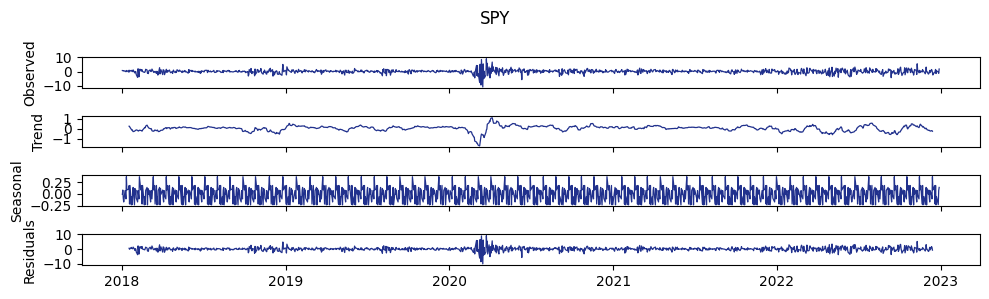

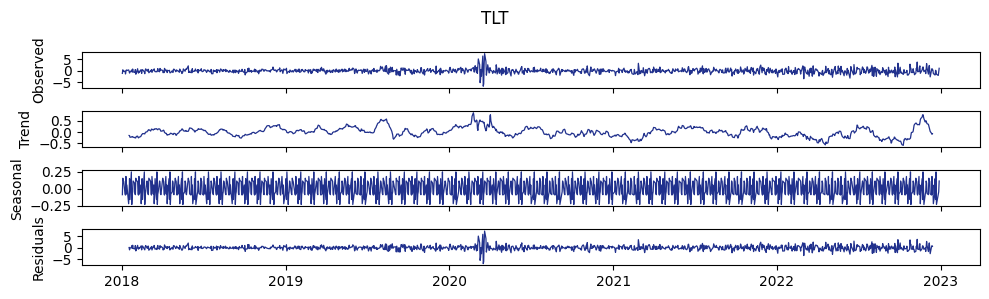

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_seasonality(df, c):
  for col in df.columns:
    result = seasonal_decompose(df[col], period=20)
    _, ax = plt.subplots(4, 1, figsize=(10,3), sharex=True)
    ax[0].plot(result.observed, color=c, linewidth=0.9)
    ax[0].set(ylabel='Observed')
    ax[1].plot(result.trend, color=c, linewidth=0.9)
    ax[1].set(ylabel='Trend')
    ax[2].plot(result.seasonal, color=c, linewidth=0.9)
    ax[2].set(ylabel='Seasonal')
    ax[3].plot(result.resid, color=c, linewidth=0.9)
    ax[3].set(ylabel='Residuals')
    plt.suptitle(f'{col}')
    plt.tight_layout()
    plt.show();


decompose_seasonality(data_train, '#49b1c3')
decompose_seasonality(data_validation, 'darkorange')
decompose_seasonality(data_test, '#21318d')

A common denominator of all the analyzed series in all subperiods is that there is no clear trend. Seasonality shows unclear behavior, particularly in the validation period. Hence, to conclude, seasonal decomposition confirmed our expectations about no clear patterns in the returns.

The last step is to check stationarity of the data. Usually with discrete (and logarithmic) returns of liquid securities we expect to confirm that our data is stationary.

A univariate test for each component series is the well-known ADF test with the following set of hypotheses:<br>
$H_0$: The data is nonstationary.<br>
$H_1$: The data is stationary.


In [ ]:
from statsmodels.tsa.stattools import adfuller

results = []
for col in data.columns:
  full_data_pvalue = adfuller(data[col])[1]
  training_data_pvalue = adfuller(data_train[col])[1]
  validation_data_pvalue = adfuller(data_validation[col])[1]
  test_data_pvalue = adfuller(data_test[col])[1]
  results.append([full_data_pvalue, training_data_pvalue, validation_data_pvalue, test_data_pvalue])

results_df = pd.DataFrame(results,
                          columns=['Entire Dataset p-value', 'Training Dataset p-value', 'Validation Dataset p-value', 'Test Dataset p-value'],
                          index=data.columns)
results_df

,Entire Dataset p-value,Training Dataset p-value,Validation Dataset p-value,Test Dataset p-value
Ticker,,,,
DBO,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GLD,0.000000e+00,0.000000e+00,1.419743e-06,3.139768e-28
SHY,6.688276e-22,5.607752e-17,0.000000e+00,4.693875e-09
SPY,2.778495e-23,1.881104e-15,4.892341e-23,8.206370e-20
TLT,1.078396e-18,7.939650e-30,0.000000e+00,8.202861e-19


As expected, the results unambiguously reject the null hypothesis, therefore the data is stationary for each individual component and in all considered timeframes.

# Step 2

The objective is to create 5 independent LSTM models, one for each portfolio component. We then use these models to calculate 25-day forecast returns.

We start with creating all the features needed for 25 day return prediction. There are various ways to determine the sufficient number of lags. One way is to conduct the Ljung-Box test for significance of autocorrelation up to the $k^{th}$ lag. However, it is a frequent case that this test results in 0, 1 or maximum 2 significant lags. Hence, here is where we employ our expert knowledge. In our opinion, to leverage the capabilities of neural network models, it is reasonable to include **6 lags**.

Working on daily data, this gives us the opportunity to use the information from the entire last business week. Even though we are predicting a 25-day ahead return, there is no need to include more lagged returns for the following reasons: since it is a common opinion that the current market price reflects all the available information and that the markets discount everything immediately, it is quite rare that an event that occurred, for example, one month ago, will still be of significance for today's price/return.

Of course, the COVID-19 pandemic differs, as we observed a crash in all markets worldwide which took months to recover. Still, this kind of events is rare enough that we need not account for it during model training.

Let us now move on to the steps of data preparation and modeling.

1. First, use 6 lagged values and daily return to predict 25-day ahead return.

In [ ]:
minLagNum = 1
maxLagNum = 7 #use 6 lagged values

data_ticker = data.copy()

lag_data = pd.DataFrame()
for column in data_ticker.columns:
  for lag in range (minLagNum, maxLagNum):
      lag_data[f'{column}_Lag_{lag}'] = data [f'{column}'].shift(lag)

lag_data

,DBO_Lag_1,DBO_Lag_2,DBO_Lag_3,DBO_Lag_4,DBO_Lag_5,DBO_Lag_6,GLD_Lag_1,GLD_Lag_2,GLD_Lag_3,GLD_Lag_4,...,SPY_Lag_3,SPY_Lag_4,SPY_Lag_5,SPY_Lag_6,TLT_Lag_1,TLT_Lag_2,TLT_Lag_3,TLT_Lag_4,TLT_Lag_5,TLT_Lag_6
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.925585,NaN,NaN,NaN,NaN,NaN,-0.091080,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.645862,NaN,NaN,NaN,NaN,NaN
2010-01-07,1.234579,0.925585,NaN,NaN,NaN,NaN,1.649959,-0.091080,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.338693,0.645862,NaN,NaN,NaN,NaN
2010-01-08,-0.696865,1.234579,0.925585,NaN,NaN,NaN,-0.618781,1.649959,-0.091080,NaN,...,0.264695,NaN,NaN,NaN,0.168193,-1.338693,0.645862,NaN,NaN,NaN
2010-01-11,0.491212,-0.696865,1.234579,0.925585,NaN,NaN,0.496303,-0.618781,1.649959,-0.091080,...,0.070425,0.264695,NaN,NaN,-0.044702,0.168193,-1.338693,0.645862,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,1.935034,0.277203,1.334276,-1.510996,-1.886792,1.296932,-0.165601,1.659448,-0.281783,0.870872,...,-0.847977,-1.180619,-2.446162,-0.639360,0.251347,-1.775712,-1.680516,-1.117080,0.390189,0.427128
2022-12-23,-0.745764,1.935034,0.277203,1.334276,-1.510996,-1.886792,-1.208536,-0.165601,1.659448,-0.281783,...,0.136849,-0.847977,-1.180619,-2.446162,-0.019276,0.251347,-1.775712,-1.680516,-1.117080,0.390189
2022-12-27,2.459018,-0.745764,1.935034,0.277203,1.334276,-1.510996,0.299832,-1.208536,-0.165601,1.659448,...,1.495247,0.136849,-0.847977,-1.180619,-1.466052,-0.019276,0.251347,-1.775712,-1.680516,-1.117080


2. Second, create return and target 25-day return.

In [ ]:
data_ret_all = pd.DataFrame()

ret_data = data
ret25_data = data.shift(25)

data_ticker = data.copy()

for col in ret_data.columns:
  data_ret_all[f'{col}_Ret'] = ret_data[col]

for col in ret25_data.columns:
  data_ret_all[f'{col}_Ret25'] = ret25_data[col]

data_ret_all.head()

,DBO_Ret,GLD_Ret,SHY_Ret,SPY_Ret,TLT_Ret,DBO_Ret25,GLD_Ret25,SHY_Ret25,SPY_Ret25,TLT_Ret25
Date,,,,,,,,,,
2010-01-05,0.925585,-0.091080,0.120371,0.264695,0.645862,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.234579,1.649959,0.012094,0.070425,-1.338693,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.696865,-0.618781,-0.024143,0.422120,0.168193,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.491212,0.496303,0.096306,0.332790,-0.044702,NaN,NaN,NaN,NaN,NaN
2010-01-11,-0.558651,1.328900,0.048006,0.139668,-0.548817,NaN,NaN,NaN,NaN,NaN


In [ ]:
def getTickerDataForDL (ticker):
  data_DL = pd.DataFrame()
  data_DL[ticker]= data_ticker[ticker]

  for lag in range (minLagNum, maxLagNum):
    data_DL[f'{ticker}_Lag_{lag}'] = lag_data[f'{ticker}_Lag_{lag}']

  data_DL[f'{ticker}_Ret'] = data_ret_all[f'{ticker}_Ret']
  data_DL[f'{ticker}_Ret25'] = data_ret_all[f'{ticker}_Ret25']

  data_DL.dropna(inplace=True)

  return data_DL

#example usage of the function
ticker_data_DL = getTickerDataForDL('GLD')
ticker_data_DL

,GLD,GLD_Lag_1,GLD_Lag_2,GLD_Lag_3,GLD_Lag_4,GLD_Lag_5,GLD_Lag_6,GLD_Ret,GLD_Ret25
Date,,,,,,,,,
2010-02-10,-0.275117,1.316804,-0.611386,0.297018,-3.983435,-0.394026,0.719888,-0.275117,-0.091080
2010-02-11,1.912095,-0.275117,1.316804,-0.611386,0.297018,-3.983435,-0.394026,1.912095,1.649959
2010-02-12,-0.084007,1.912095,-0.275117,1.316804,-0.611386,0.297018,-3.983435,-0.084007,-0.618781
2010-02-16,2.410316,-0.084007,1.912095,-0.275117,1.316804,-0.611386,0.297018,2.410316,0.496303
2010-02-17,-0.337532,2.410316,-0.084007,1.912095,-0.275117,1.316804,-0.611386,-0.337532,1.328900
...,...,...,...,...,...,...,...,...,...
2022-12-22,-1.208536,-0.165601,1.659448,-0.281783,0.870872,-1.635931,-0.243302,-1.208536,-0.229610
2022-12-23,0.299832,-1.208536,-0.165601,1.659448,-0.281783,0.870872,-1.635931,0.299832,-0.726742
2022-12-27,0.843001,0.299832,-1.208536,-0.165601,1.659448,-0.281783,0.870872,0.843001,-0.689364


Effectively, after including the 25-day-ahead return, our initial training dataset shortens by 25 observations.

3. Build the LSTM model with the following specifications:
- Each model has 8 features: the current return, 6 lagged returns and the 25-day-ahead return, which is assigned as target column
- An LSTM layer with 50 neurons and ReLU activation function
- A dense layer with 1 neuron
- Adam optimizer and MSE loss function to be minimized.

We build 5 identical models.

In [ ]:
NUM_FEATURES = 8
TARGET_COL = 8  # actual col is 9 but index is 8

# Deep Learning models
models = []
for i in range(len(tickers)):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(25, NUM_FEATURES)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    models.append(model)

4. Train the models and assess their performance.

First 5 rows of training data
                  SPY  SPY_Lag_1  SPY_Lag_2  SPY_Lag_3  SPY_Lag_4  SPY_Lag_5  \
Date                                                                          
2010-02-10 -0.195852   1.255959  -0.721882   0.206694  -3.086551  -0.498309   
2010-02-11  1.046643  -0.195852   1.255959  -0.721882   0.206694  -3.086551   
2010-02-12 -0.083221   1.046643  -0.195852   1.255959  -0.721882   0.206694   
2010-02-16  1.573496  -0.083221   1.046643  -0.195852   1.255959  -0.721882   
2010-02-17  0.473833   1.573496  -0.083221   1.046643  -0.195852   1.255959   

            SPY_Lag_6   SPY_Ret  SPY_Ret25  
Date                                        
2010-02-10   1.210327 -0.195852   0.264695  
2010-02-11  -0.498309  1.046643   0.070425  
2010-02-12  -3.086551 -0.083221   0.422120  
2010-02-16   0.206694  1.573496   0.332790  
2010-02-17  -0.721882  0.473833   0.139668   

First 5 rows of training data
                  TLT  TLT_Lag_1  TLT_Lag_2  TLT_Lag_3  TLT_Lag_4  T

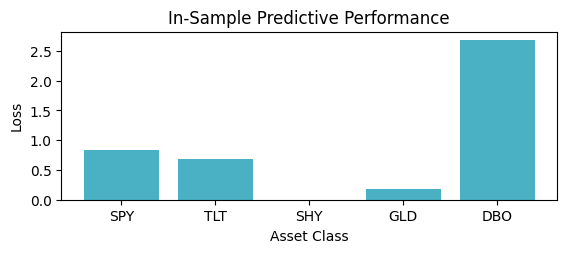

In [ ]:
## Train the models
for i in range(len(tickers)):
    data_DL = getTickerDataForDL(tickers[i])
    # Split the datast into training, validation and test sets
    data_train = data_DL.iloc[:1609, :]
    print('First 5 rows of training data\n', data_train.head(), '\n')
    X_train = []
    y_train = []
    for j in range(25, len(data_train)):
        X_train.append(data_train.iloc[j-25:j, 0:NUM_FEATURES].values)
        y_train.append(data_train.iloc[j, TARGET_COL])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], NUM_FEATURES))
    models[i].fit(X_train, y_train, epochs=20, batch_size=32, verbose=False)

# In-sample predictive performance
in_sample_performance = []
for i in range(len(tickers)):
    data_DL = getTickerDataForDL(tickers[i])
    data_train = data_DL.iloc[:1609, :]
    X_train = []
    y_train = []
    for j in range(25, len(data_train)):
        X_train.append(data_train.iloc[j-25:j,  0:NUM_FEATURES].values)
        y_train.append(data_train.iloc[j, TARGET_COL])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], NUM_FEATURES))
    loss = models[i].evaluate(X_train, y_train)
    in_sample_performance.append(loss)

# Print the results
print('In-sample predictive performance:')
for i in range(len(tickers)):
    print(f'{tickers[i]}: {in_sample_performance[i]}')
print('')

# Plot the results
plt.subplot(2, 1, 1)
plt.bar(tickers, in_sample_performance, color='#49b1c3')
plt.title('In-Sample Predictive Performance')
plt.xlabel('Asset Class')
plt.ylabel('Loss')
plt.show();

38/38 [==============================] - 0s 6ms/step - loss: 5.0823
Out-of-sample predictive performance:
SPY: 2.3791511058807373
TLT: 0.877914309501648
SHY: 0.0075754099525511265
GLD: 0.16210249066352844
DBO: 5.082338809967041



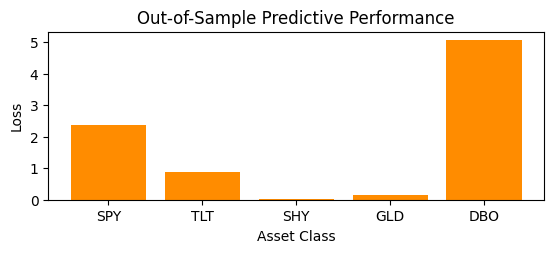

In [ ]:
#Test the models out-of-sample
out_of_sample_performance = []
for i in range(len(tickers)):
    data_DL = getTickerDataForDL(tickers[i])
    data_test = data_DL.iloc[2012:, :]
    X_test = []
    y_test = []
    for j in range(25, len(data_test)):
        X_test.append(data_test.iloc[j-25:j, 0:NUM_FEATURES].values)
        y_test.append(data_test.iloc[j, TARGET_COL])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], NUM_FEATURES))
    loss = models[i].evaluate(X_test, y_test)
    out_of_sample_performance.append(loss)

 # Print the results
print('Out-of-sample predictive performance:')
for i in range(len(tickers)):
    print(f'{tickers[i]}: {out_of_sample_performance[i]}')
print('')

# plot the results
plt.subplot(2, 1, 1)
plt.bar(tickers, out_of_sample_performance, color='darkorange')
plt.title('Out-of-Sample Predictive Performance')
plt.xlabel('Asset Class')
plt.ylabel('Loss')
plt.show();

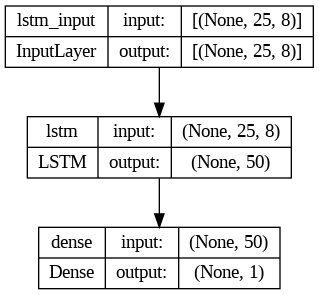

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(models[0], to_file='model.png', show_shapes=True, show_layer_names=True)

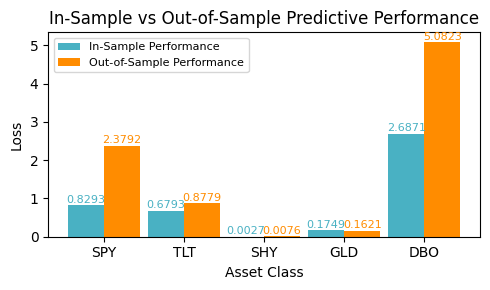

In [ ]:
# Comparing
plt.figure(figsize=(5,3))
bar_width = 0.45
tick_positions = np.arange(len(tickers))
# In-sample predictive performance
plt.bar(tick_positions-bar_width/2, in_sample_performance, label='In-Sample Performance', color='#49b1c3', width=bar_width)
# Out-of-sample predictive performance
plt.bar(tick_positions+bar_width/2, out_of_sample_performance, label='Out-of-Sample Performance', color='darkorange', width=bar_width)
plt.title('In-Sample vs Out-of-Sample Predictive Performance')
plt.xticks(tick_positions, tickers)
# Add in-sample performance labels
for i, value in enumerate(in_sample_performance):
    plt.text(tick_positions[i]-bar_width/2, value+0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=8, color='#49b1c3')
# Add out-of-sample performance labels
for i, value in enumerate(out_of_sample_performance):
    plt.text(tick_positions[i] + bar_width/2, value+0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=8, color='darkorange')
plt.xlabel('Asset Class')
plt.ylabel('Loss')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('in_sample_and_out_of_sample_performance.png')
plt.show();

Here we have compared the performance of our individual-asset models on the training and test set. We can see that the model for SHY has the least loss, both training and test, whereas the model for DBO has the highest loss.

It is beneficial to also use the validation set in order to tune hyperparameters of each model individually. Neural networks have many hyperparameters, therefore, due to limited computing capacity, we fix the following hyperparameters:
- Number of LSTM layers: 1
- Number of dense layers: 1
- Number of neurons in the dense layer: 1
- Optimizer and loss function: Adam and MSE, respectively.

We tune each model's hyperparameters:
- Number of neurons in the LSTM layer
- Number of epochs
- Minibatch size.

In [ ]:
!pip install scikeras -q
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor

# Function to create model
def create_model(neurons=50, batch_size=32, epochs=20):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(25, NUM_FEATURES)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Deep Learning models
models_tuned = []
in_sample_performance_tuned = []
# Validation dataset to choose the best model
data_val = data_DL.iloc[1609:2012, :]
# Hyperparameter search space
param_dist = {
    'neurons': [25, 50, 100, 150],
    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 20, 30]
}

# Function to prepare data
def prepare_data(data):
    X = []
    y = []
    for j in range(25, len(data)):
        X.append(data.iloc[j-25:j, 0:NUM_FEATURES].values)
        y.append(data.iloc[j, TARGET_COL])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], NUM_FEATURES))
    return X, y

for i in range(len(tickers)):
    model = KerasRegressor(model=create_model, neurons=50, verbose=False)
    ps = PredefinedSplit(test_fold=data_val.iloc[:, i])
    # Perform Randomized Search
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=10,
        cv=ps,
        verbose=2,
        n_jobs=-1
    )
    data_DL = getTickerDataForDL(tickers[i])
    data_train = data_DL.iloc[:1609, :]
    X_train, y_train = prepare_data(data_train)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    models_tuned.append(best_model)
    pred = best_model.predict(X_train)
    loss = mean_squared_error(y_train, pred)
    in_sample_performance_tuned.append(loss)

# Print the results
print('In-sample predictive performance:')
for i in range(len(tickers)):
    print(f'{tickers[i]}: {in_sample_performance_tuned[i]}')
print('')

# Test models' out-of-sample performance
out_of_sample_performance_tuned = []
for i in range(len(tickers)):
    data_DL = getTickerDataForDL(tickers[i])
    data_test = data_DL.iloc[2012:, :]
    X_test = []
    y_test = []
    for j in range(25, len(data_test)):
        X_test.append(data_test.iloc[j-25:j, 0:NUM_FEATURES].values)
        y_test.append(data_test.iloc[j, TARGET_COL])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], NUM_FEATURES))
    loss = models[i].evaluate(X_test, y_test)
    out_of_sample_performance_tuned.append(loss)

 # Print the results
print('Out-of-sample predictive performance:')
for i in range(len(tickers)):
    print(f'{tickers[i]}: {out_of_sample_performance_tuned[i]}')
print('')

Fitting 9 folds for each of 10 candidates, totalling 90 fits
Fitting 9 folds for each of 10 candidates, totalling 90 fits
Fitting 9 folds for each of 10 candidates, totalling 90 fits
Fitting 9 folds for each of 10 candidates, totalling 90 fits
Fitting 9 folds for each of 10 candidates, totalling 90 fits
In-sample predictive performance:
SPY: 0.7177306995179816
TLT: 0.8857411040636259
SHY: 0.0027961155745103625
GLD: 0.952962173939882
DBO: 2.7846518498907242

38/38 [==============================] - 0s 6ms/step - loss: 5.0823
Out-of-sample predictive performance:
SPY: 2.3791511058807373
TLT: 0.877914309501648
SHY: 0.0075754099525511265
GLD: 0.16210249066352844
DBO: 5.082338809967041



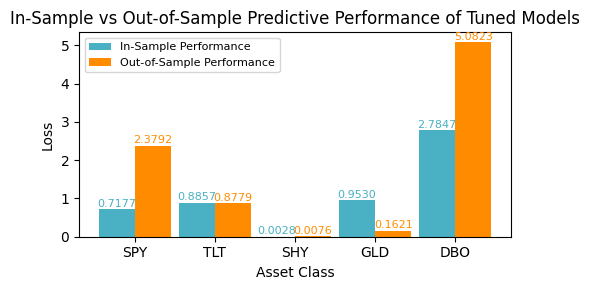

In [ ]:
# Plot the results
# Comparing
plt.figure(figsize=(5,3))
bar_width = 0.45
tick_positions = np.arange(len(tickers))
# In-sample predictive performance
plt.bar(tick_positions-bar_width/2, in_sample_performance_tuned, label='In-Sample Performance', color='#49b1c3', width=bar_width)
# Out-of-sample predictive performance
plt.bar(tick_positions+bar_width/2, out_of_sample_performance_tuned, label='Out-of-Sample Performance', color='darkorange', width=bar_width)
plt.title('In-Sample vs Out-of-Sample Predictive Performance of Tuned Models')
plt.xticks(tick_positions, tickers)
# Add in-sample performance labels
for i, value in enumerate(in_sample_performance_tuned):
    plt.text(tick_positions[i]-bar_width/2, value+0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=8, color='#49b1c3')
# Add out-of-sample performance labels
for i, value in enumerate(out_of_sample_performance_tuned):
    plt.text(tick_positions[i] + bar_width/2, value+0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=8, color='darkorange')
plt.xlabel('Asset Class')
plt.ylabel('Loss')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('in_sample_and_out_of_sample_performance_tuned.png')
plt.show();

Despite trying to tune hyperparameters, based on the obtained MSE values neither model outperformed the baseline models with default parameters. Therefore, we proceed with the initial models. Such a situation might stem from the fact that we are modeling discrete returns, stochastic processes of white-noise nature.

As a final part of this step, we compare the performance of our portfolio with a baseline buy-and-hold strategy by taking returns and cumulative returns over the test period.

We have applied a computational fix to handle numerical issue with division by 0. In reality, there are no 0-returns to divide by, however numerically the numbers are so close to 0 that Python treats them as such. Therefore, a workaround solution is that if the result is numerical $+\infty$, we replace it with +100% return, and analogically, -100% for numerical $-\infty$.

In [ ]:
# Trading strategy
predictions = []
for i in range(len(tickers)):
    data_DL = getTickerDataForDL(tickers[i])
    data_test = data_DL.iloc[2012:, :]
    X_test = []
    for j in range(25, len(data_test)):
        X_test.append(data_test.iloc[j-25:j, 0:NUM_FEATURES].values)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], NUM_FEATURES))
    prediction = models[i].predict(X_test, verbose=False)
    predictions.append(prediction)
# Backtest the trading strategy
portfolio_returns = []
for i in range(len(data_test)-25):
    returns = []
    for j in range(len(tickers)):
        if predictions[j][i] > np.mean(predictions[j][i:i+25]):
            returns.append(data_test.iloc[i+25, j]/pd.to_numeric(data_test.iloc[i, j]))
        else:
            returns.append(data_test.iloc[i, j]/pd.to_numeric(data_test.iloc[i+25, j]))
    portfolio_returns.append(np.mean(returns))
portfolio_returns = pd.Series(pd.to_numeric(portfolio_returns), index=data_test.index[25:]).fillna(0.0).replace({-np.inf:-100, np.inf:100})
# Print the results
print("Trading strategy returns:")
print(portfolio_returns)
print("")

# Buy-and-hold return of an Equally weighted portfolio
equally_weighted_returns = []
for i in range(len(data_test)-25):
    returns = []
    for j in range(len(tickers)):
        returns.append(data_test.iloc[i+25, j]/pd.to_numeric(data_test.iloc[i, j]))
    equally_weighted_returns.append(np.mean(returns))
equally_weighted_returns = pd.Series(pd.to_numeric(equally_weighted_returns), index=data_test.index[25:]).fillna(0.0).replace({-np.inf:-100, np.inf:100})
# Print the results
print("Buy-and-hold returns:")
print(equally_weighted_returns)

Trading strategy returns:
Date
2018-03-15   -1.146064
2018-03-16   -2.954899
2018-03-19   -0.125516
2018-03-20   -1.418468
2018-03-21    2.683529
                ...   
2022-12-22   -2.297471
2022-12-23   -2.084657
2022-12-27    0.027736
2022-12-28    0.457791
2022-12-29   -0.906753
Length: 1208, dtype: float64

Buy-and-hold returns:
Date
2018-03-15    0.229926
2018-03-16   -0.111736
2018-03-19   -0.083417
2018-03-20    0.628060
2018-03-21    2.003251
                ...   
2022-12-22    0.001012
2022-12-23    0.215671
2022-12-27    0.046265
2022-12-28    0.614061
2022-12-29    0.355684
Length: 1208, dtype: float64


We also tried to check cumulative returns. Due to the previously encountered numerical issues we were unable to obtain fully accurate results.

In [ ]:
cumulative_portfolio_returns = np.cumprod(100+portfolio_returns) - 100
cumulative_equally_weighted_returns = np.cumprod(100+equally_weighted_returns) - 100
cumulative_portfolio_returns = pd.Series(cumulative_portfolio_returns, index=portfolio_returns.index)
cumulative_equally_weighted_returns = pd.Series(cumulative_equally_weighted_returns, index=equally_weighted_returns.index)
cumulative_portfolio_returns

Date
2018-03-15   -1.146064e+00
2018-03-16    9.493290e+03
2018-03-19    9.580249e+05
2018-03-20    9.445332e+07
2018-03-21    9.698811e+09
                  ...     
2022-12-22   -1.000000e+02
2022-12-23   -1.000000e+02
2022-12-27   -1.000000e+02
2022-12-28   -1.000000e+02
2022-12-29   -1.000000e+02
Length: 1208, dtype: float64

In [ ]:
cumulative_equally_weighted_returns

Date
2018-03-15    2.299262e-01
2018-03-16    9.911793e+03
2018-03-19    1.000244e+06
2018-03-20    1.006626e+08
2018-03-21    1.026792e+10
                  ...     
2022-12-22   -1.000000e+02
2022-12-23   -1.000000e+02
2022-12-27   -1.000000e+02
2022-12-28   -1.000000e+02
2022-12-29   -1.000000e+02
Length: 1208, dtype: float64

The numerical issues are also visible in the below graph of both strategies' returns. Because $-\infty$, replaced with -100%, occurs relatively soon, the entire portfolio is wiped out and the cumulative return stays at a constant -100%, regardless of the strategy.

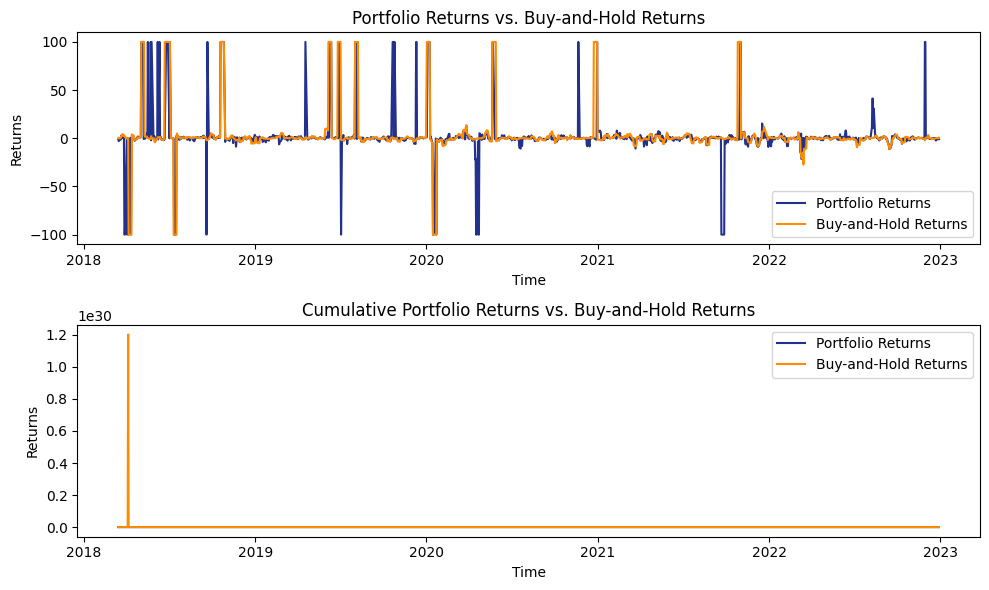

In [ ]:
# Portfolio returns vs. Buy-and-hold returns
fig, ax = plt.subplots(2, 1, figsize=(10,6))

ax[0].plot(portfolio_returns, label='Portfolio Returns', color='#21318d')
ax[0].plot(equally_weighted_returns, label='Buy-and-Hold Returns', color='darkorange')
ax[0].set(title='Portfolio Returns vs. Buy-and-Hold Returns', xlabel='Time', ylabel='Returns')
ax[0].legend()

ax[1].plot(cumulative_portfolio_returns, label='Portfolio Returns', color='#21318d')
ax[1].plot(cumulative_equally_weighted_returns, label='Buy-and-Hold Returns', color='darkorange')
ax[1].set(title='Cumulative Portfolio Returns vs. Buy-and-Hold Returns', xlabel='Time', ylabel='Returns')
#ax[1].set_ylim(-110, 100)
ax[1].legend()

plt.tight_layout()
plt.savefig('portfolio_vs_buy_and_hold_returns.png')
plt.show();

In [ ]:
print(cumulative_portfolio_returns[cumulative_portfolio_returns>-100], '\n')
print(cumulative_equally_weighted_returns[cumulative_equally_weighted_returns>-100])

Date
2018-03-15   -1.146064e+00
2018-03-16    9.493290e+03
2018-03-19    9.580249e+05
2018-03-20    9.445332e+07
2018-03-21    9.698811e+09
2018-03-22    9.731316e+11
2018-03-23    9.857872e+13
2018-03-26    9.882265e+15
2018-03-27    9.946484e+17
dtype: float64 

Date
2018-03-15    2.299262e-01
2018-03-16    9.911793e+03
2018-03-19    1.000244e+06
2018-03-20    1.006626e+08
2018-03-21    1.026792e+10
2018-03-22    1.045871e+12
2018-03-23    1.089147e+14
2018-03-26    1.132475e+16
2018-03-27    1.167875e+18
2018-03-28    1.188659e+20
2018-03-29    1.212333e+22
2018-04-02    1.206978e+24
2018-04-03    1.205312e+26
2018-04-04    1.204320e+28
2018-04-05    1.202701e+30
dtype: float64


Given the numerical issues, it is ultimately impossible to determine whether the buy-and-hold strategy outperforms our trading strategy. Given the last non-negative-numerical-infinity score of both cumulative returns, we can say that our portfolio did not outperform the baseline equally weighted portfolio.

# Step 3

Finally, we train a model with LSTM architecture and 5-dimensional input.

In [ ]:
data_train = data_ret_all.dropna().copy().iloc[:2012, :]
data_test = data_ret_all.dropna().copy().iloc[2012:, :]
data_train.tail()
data_test.tail()

,DBO_Ret,GLD_Ret,SHY_Ret,SPY_Ret,TLT_Ret,DBO_Ret25,GLD_Ret25,SHY_Ret25,SPY_Ret25,TLT_Ret25
Date,,,,,,,,,,
2022-12-22,-0.745764,-1.208536,-0.061439,-1.426622,-0.019276,-1.722101,-0.229610,0.012337,-0.762881,2.186870
2022-12-23,2.459018,0.299832,-0.049112,0.575229,-1.466052,-3.444107,-0.726742,-0.123083,-0.305971,-1.055230
2022-12-27,0.733328,0.843001,-0.135308,-0.394341,-1.977282,-1.752190,-0.689364,-0.110893,0.454026,-0.687721
2022-12-28,-1.058898,-0.450581,0.000000,-1.242798,-0.589170,-0.382165,-0.558995,-0.024660,-0.363601,0.421509
2022-12-29,-0.468227,0.559825,0.073901,1.800032,1.135094,1.598469,0.117372,0.074019,1.345695,1.419141


We define the model to have 3 LSTM layers and 2 dense layer with 128, 64, 64 and 5 neurons, respectively. Additionally, the hidden dense layer has ReLU activation function. We use the Adam optimizer and MSE as loss fucntion.

We train the model on all 5 portfolio components at the same time, so that it potentially captures the interactions between them and improve predictions.

While training the model in 20 epochs and minibatches of 64.

In [ ]:
# Model architecture
inputs = tf.keras.Input(shape=(25, 5))  # Input shape: 25-day returns for 5 ETFs
x = layers.LSTM(128, return_sequences=True)(inputs)  # LSTM layer with return sequences
x = layers.LSTM(64)(x)  # LSTM layer
x = layers.Dense(64, activation='relu')(x)  # Dense layer
outputs = layers.Dense(5)(x)  # Output layer with 5 units, one for each ETF

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use mean squared error as the loss function

# training data
X_train = []
y_train = []

for i in range(25, len(data_train)):
    X_train.append(data_train.iloc[i-25:i, :5].values)
    y_train.append(data_train.iloc[i, 5:].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, shuffle=False, verbose=False)

# test data
X_test = []
y_test = []

for i in range(25, len(data_test)):
    X_test.append(data_test.iloc[i-25:i, :5].values)
    y_test.append(data_test.iloc[i, 5:].values)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predictions on the test data
predictions = model.predict(X_test, verbose=False)
predictions = pd.DataFrame(predictions, index=data_test.index[25:], columns=tickers)
predictions.head()

,SPY,TLT,SHY,GLD,DBO
Date,,,,,
2018-03-15,-1.073804,-0.049985,-0.003367,-0.405560,0.452100
2018-03-16,-1.068100,-0.048014,-0.003591,-0.403410,0.448652
2018-03-19,0.824400,0.019518,0.007069,0.466733,-0.329412
2018-03-20,0.818139,0.024043,0.007420,0.460745,-0.331693
2018-03-21,0.827417,0.019834,0.008489,0.467985,-0.332081


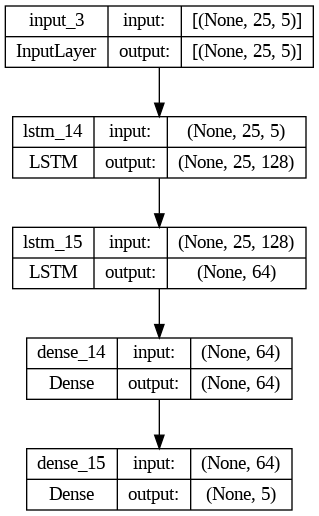

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_multi.png', show_shapes=True, show_layer_names=True)

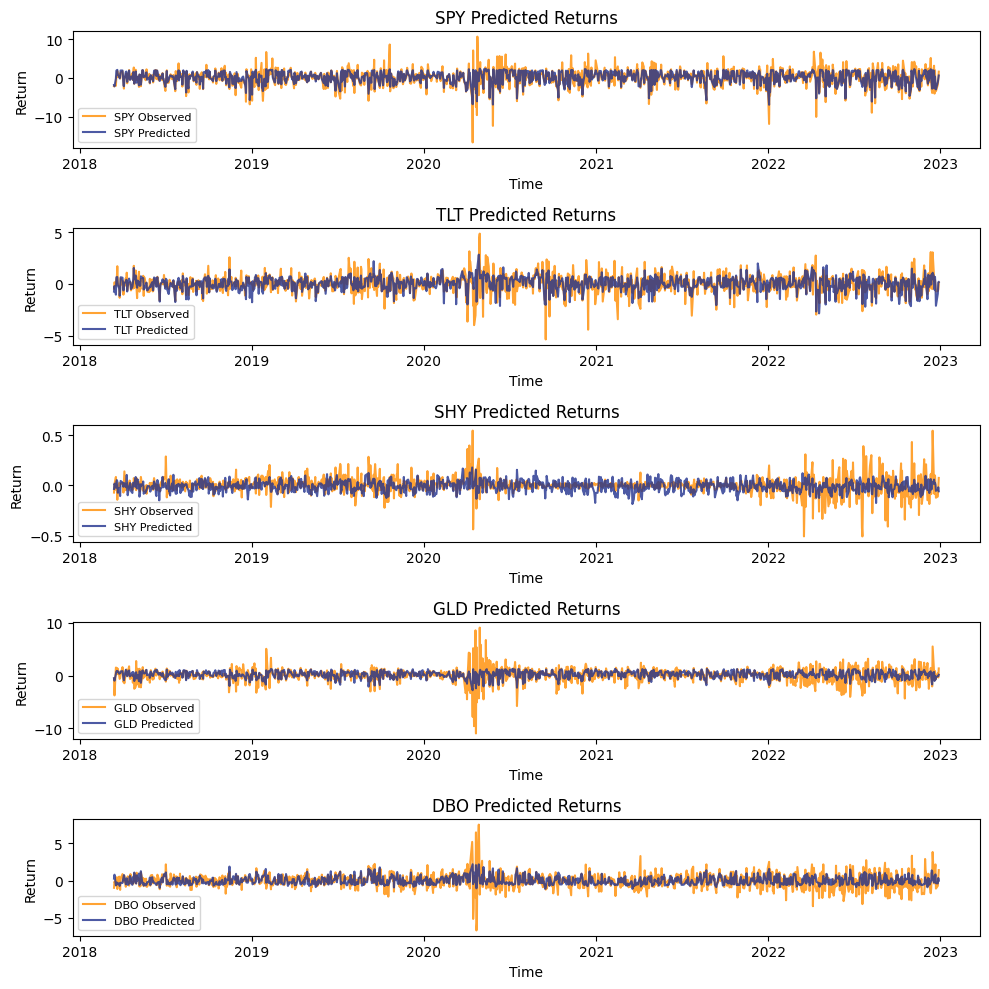

In [ ]:
y_test = pd.DataFrame(y_test, index=data_test.index[25:], columns=tickers)

fig, ax = plt.subplots(5, 1, figsize=(10,10))
for i, ticker in enumerate(tickers):
  ax[i].plot(y_test[ticker], label=f'{ticker} Observed', color='darkorange', alpha=0.8)
  ax[i].plot(predictions[ticker], label=f'{ticker} Predicted', color='#21318d', alpha=0.8)
  ax[i].set(title=f'{ticker} Predicted Returns', xlabel='Time', ylabel='Return')
  ax[i].legend(fontsize=8, loc='lower left')
plt.tight_layout()
plt.savefig('multivariate_model_predictions.png')
plt.show();

Here we construct a portofolio strategy - Long 3 highest return EFT and short 2 lowest return ETF. The Portfolio weights add to 1, i.e. 100%.

The Portfolio is rebalanced every 25 days using the same approach.

The equally weighted portfolio remains constant in terms of the weight composition.

Additionally, we assume that the risk-free rate is 1.5%.

In [ ]:
# Define a trading strategy using out-of-sample predictions
def trading_strategy(pred, i):
  # Use RFR = 1.5%
  rf = (1.015**(1/360))-1

  # New dataframe to stock_data.
  stock_data = pd.DataFrame(columns=['security','e_returns','vol', 'sr' ]).set_index('security')
  portfolio_df = pred.iloc[i:i+25, :]

  #Calculate volatilities, expected returns and sharpe ratios.
  for security in portfolio_df.columns:
    vol = portfolio_df[security].std() # volatility
    e_r = portfolio_df[security].mean() # excpected returns
    sr = (e_r-rf)/vol # Sharpe ratio
    stock_data.loc[security]= [e_r, vol,sr]
    #sort by Sharpe Ratio
    stock_data = stock_data.sort_values(by=['e_returns'], ascending=False)

  p_df = pd.DataFrame()

  #create portfolio long 3 ETFs and short 2 ETFS = .5 +.5 .5 - .25 -.25  = 100%
  #go Long top 3 returns and short bottom 2
  p_df['strategy']= (0.5*portfolio_df[stock_data.index[0]]
                      + 0.5*portfolio_df[stock_data.index[1]]
                      + 0.5*portfolio_df[stock_data.index[2]]
                      - 0.25*portfolio_df[stock_data.index[3]]
                      - 0.25*portfolio_df[stock_data.index[4]])
  #is there an easier way to do this ?
  p_df['equally_weighted'] = 0.2*(portfolio_df[tickers[0]]
                                  + portfolio_df[tickers[1]]
                                  + portfolio_df[tickers[2]]
                                  + portfolio_df[tickers[3]]
                                  + portfolio_df[tickers[4]])

  return p_df


# Apply and rebalance every 25 days
port_complete_df = pd.DataFrame()
for i in range (0, len(predictions), 25):
  # Applying trading strategy using out-of-sample predictions and rebalance
  port_df = trading_strategy(predictions, i)
  port_complete_df = port_complete_df.append(port_df)

port_complete_df = port_complete_df.fillna(0.0).replace({-np.inf: -100, np.inf: 100})
port_complete_df

,strategy,equally_weighted
Date,,
2018-03-15,-1.089883,-0.578473
2018-03-16,-1.720962,-0.512641
2018-03-19,0.474311,-0.308914
2018-03-20,1.253872,0.607253
2018-03-21,1.233762,0.611882
...,...,...
2022-12-22,0.496251,-0.348410
2022-12-23,0.904601,-1.166712
2022-12-27,0.272364,-0.502209


In [ ]:
# Backtest the trading strategy in the test period
cumulative_returns_strategy = pd.to_numeric(np.cumprod(100+port_complete_df['strategy'])-100).replace(np.inf, 10e10) # Cumulative returns
print(cumulative_returns_strategy)
# Calculate buy-and-hold returns for comparison
cumulative_returns_buy_and_hold = pd.to_numeric(np.cumprod(100+port_complete_df['equally_weighted'])-100).replace(np.inf, 10e10)  # Cumulative return
print(cumulative_returns_buy_and_hold)

Date
2018-03-15   -1.089882e+00
2018-03-16    9.620791e+03
2018-03-19    9.765898e+05
2018-03-20    9.889354e+07
2018-03-21    1.001137e+10
                  ...     
2022-12-22    1.000000e+11
2022-12-23    1.000000e+11
2022-12-27    1.000000e+11
2022-12-28    1.000000e+11
2022-12-29    1.000000e+11
Name: strategy, Length: 1208, dtype: float64
Date
2018-03-15   -5.784760e-01
2018-03-16    9.791185e+03
2018-03-19    9.859629e+05
2018-03-20    9.920499e+07
2018-03-21    9.981211e+09
                  ...     
2022-12-22    1.000000e+11
2022-12-23    1.000000e+11
2022-12-27    1.000000e+11
2022-12-28    1.000000e+11
2022-12-29    1.000000e+11
Name: equally_weighted, Length: 1208, dtype: float64


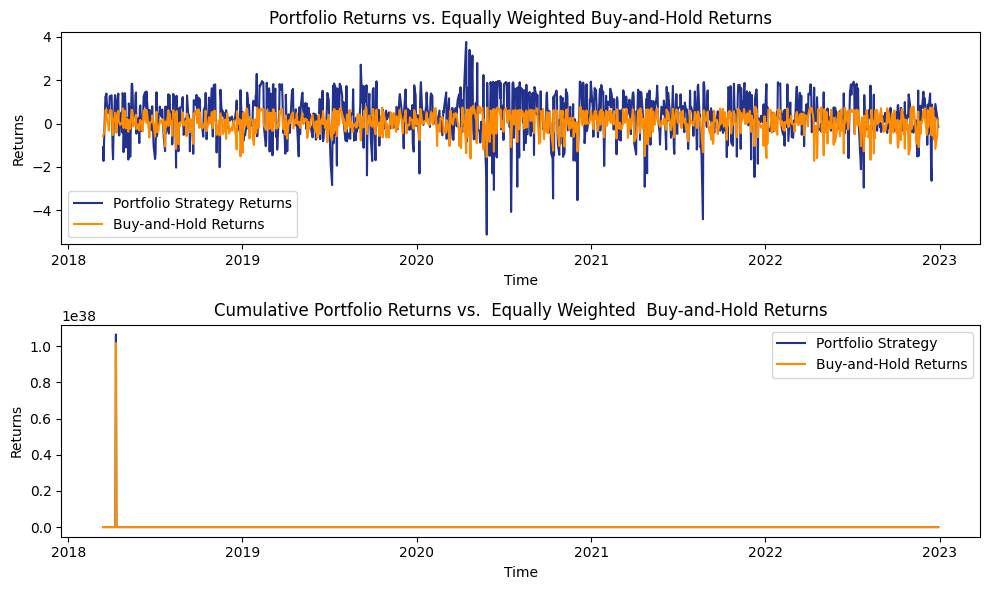

In [ ]:
# Portfolio returns vs. Buy-and-hold returns
fig, ax = plt.subplots(2, 1, figsize=(10,6))

ax[0].plot(port_complete_df['strategy'], label='Portfolio Strategy Returns', color='#21318d')
ax[0].plot(port_complete_df['equally_weighted'], label='Buy-and-Hold Returns', color='darkorange')
ax[0].set(title='Portfolio Returns vs. Equally Weighted Buy-and-Hold Returns', xlabel='Time', ylabel='Returns')
ax[0].legend()

ax[1].plot(cumulative_returns_strategy, label='Portfolio Strategy', color='#21318d')
ax[1].plot(cumulative_returns_buy_and_hold, label='Buy-and-Hold Returns', color='darkorange')
ax[1].set(title='Cumulative Portfolio Returns vs.  Equally Weighted  Buy-and-Hold Returns', xlabel='Time', ylabel='Returns')
#ax[1].set_ylim(-10e3, 10e6)
ax[1].legend()

plt.tight_layout()
plt.savefig('multivariate_portfolio_vs_buy_and_hold_returns.png')
plt.show();

In [ ]:
# Print and compare results
print("Cumulative Returns of Trading Strategy:", cumulative_returns_strategy[-1])
print("Cumulative Returns of Buy-and-Hold Strategy:", cumulative_returns_buy_and_hold[-1])

Cumulative Returns of Trading Strategy: 100000000000.0
Cumulative Returns of Buy-and-Hold Strategy: 100000000000.0


As in the case of univariate models, due to the numerical issues with division by 0, we are unable to compare the model performance accurately.

To assess the models before the occurrence of $+\infty$, we compare the last available performance.

In [ ]:
# Print and compare results
print("Cumulative Returns of Trading Strategy:\n", cumulative_returns_strategy[cumulative_returns_strategy<10e10], '\n')
print("Cumulative Returns of Buy-and-Hold Strategy:\n", cumulative_returns_buy_and_hold[cumulative_returns_buy_and_hold<10e10])

Cumulative Returns of Trading Strategy:
 Date
2018-03-15   -1.089882e+00
2018-03-16    9.620791e+03
2018-03-19    9.765898e+05
2018-03-20    9.889354e+07
2018-03-21    1.001137e+10
Name: strategy, dtype: float64 

Cumulative Returns of Buy-and-Hold Strategy:
 Date
2018-03-15   -5.784760e-01
2018-03-16    9.791185e+03
2018-03-19    9.859629e+05
2018-03-20    9.920499e+07
2018-03-21    9.981211e+09
Name: equally_weighted, dtype: float64


Before encountering numerical issues, the strategy based on the joint model predictions generate higher cumulative returns.

At this point, we can finally compare the performance of both trading strategies. Even though, given the model performance, the strategy based on the multivariate model did not bring much improvement, then, comparing the trading strategies applied, the univariate models resulted in bankruptcy while the multivariate model generated profits.

This is possibly because the multivariate model is able to capture the interdependencies occurring among the portfolio components. Conversely, the univariate models, by their nature, do not account for the potential interactions between portfolio components (there is an implicit assumption of independence of the modeled series).

An overall conclusion is that when we decide to build portfolios of more than one component and employ advanced quantitative techniques for management, it will most likely be beneficial to build a multivariate model capable of capturing (complex) relationships between its components.